In [2]:
import sys

PROJECT_ROOT = r"C:\Users\laksh\microstructure-project"

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("sys.path[0:5] =")
for p in sys.path[:5]:
    print("  ", p)


sys.path[0:5] =
   C:\Users\laksh\microstructure-project
   C:\Users\laksh\AppData\Local\Programs\Python\Python311\python311.zip
   C:\Users\laksh\AppData\Local\Programs\Python\Python311\DLLs
   C:\Users\laksh\AppData\Local\Programs\Python\Python311\Lib
   C:\Users\laksh\AppData\Local\Programs\Python\Python311


In [3]:
import os

print("CWD:", os.getcwd())
print("Project root exists:", os.path.isdir(r"C:\Users\laksh\microstructure-project"))
print("src exists:", os.path.isdir(r"C:\Users\laksh\microstructure-project\src"))
print("__init__ exists:",
      os.path.isfile(r"C:\Users\laksh\microstructure-project\src\__init__.py"))


CWD: C:\Users\laksh\microstructure-project\notebooks
Project root exists: True
src exists: True
__init__ exists: True


In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from typing import List, Tuple


class GrainSequenceDataset(Dataset):
  

    def __init__(
        self,
        csv_paths: List[str],
        target_col: str = "EqVonMisesStress",
        ngr_col: str = "ngr",
        time_col: str = "fileID",
        min_timesteps: int = 2,
    ):
        # 1) Load and concat
        dfs = []
        for p in csv_paths:
            df = pd.read_csv(p)
            dfs.append(df)
        df_all = pd.concat(dfs, ignore_index=True)

        # Drop useless index column
        if "Unnamed: 0" in df_all.columns:
            df_all = df_all.drop(columns=["Unnamed: 0"])

        self.ngr_col = ngr_col
        self.time_col = time_col
        self.target_col = target_col

       
        feature_cols = [
            "Euler_1", "Euler_2", "Euler_3",
            "AvgMisorientations",
            "EquivalentDiameters",
            "FeatureVolumes",
            "NumCells",
            "Neighborhoods",
            "NumNeighbors",
            "SurfaceFeatures",
            "SurfaceAreaVolumeRatio",
            "FeatureBoundaryElementFrac",
            "Omega3s",
            "AspectRatios_0",
            "AspectRatios_1",
            "F7List",
            "F1List",
            "F1sptList",
            "mPrimeList",
            "euler_1", "euler_2", "euler_3",
            "x", "y", "z",
            "GBEuc",
            "TJEuc",
            "QPEuc",
            "Taylor",
            "KernelAvg",
            "hotspot",
            "001_IPF_0", "001_IPF_1", "001_IPF_2",
            "100_IPF_0", "100_IPF_1", "100_IPF_2",
            "111_IPF_0", "111_IPF_1", "111_IPF_2",
            "Schmid",
        ]

        # Keep only columns that actually exist (in case of any mismatch)
        feature_cols = [c for c in feature_cols if c in df_all.columns]

        self.feature_cols = feature_cols

        print("Using feature columns:")
        print(self.feature_cols)

        # 3) Build sequences grouped by grain
        sequences: List[Tuple[np.ndarray, float]] = []

        grouped = df_all.groupby(ngr_col)

        for ngr_id, g in grouped:
            g = g.sort_values(time_col)

            if len(g) < min_timesteps:
                continue

            # Numeric-only features
            X = g[self.feature_cols].to_numpy(dtype=np.float32)  # (T, F)

            # Target = final EqVonMisesStress
            y = float(g[target_col].iloc[-1])

            sequences.append((X, y))

        if len(sequences) == 0:
            raise RuntimeError("No grain sequences were built; check your filters.")

        self.sequences = sequences
        self.num_features = len(self.feature_cols)

        print(
            f"GrainSequenceDataset: {len(self.sequences)} grains, "
            f"{self.num_features} features, target={self.target_col}"
        )

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        X, y = self.sequences[idx]
        X = torch.from_numpy(X)       # (T, F)
        y = torch.tensor([y], dtype=torch.float32)
        return X, y



In [19]:
import pandas as pd
import numpy as np

csv_paths = [
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro1_all_grainwise.csv",
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro2_all_grainwise.csv",
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro3_all_grainwise.csv",
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro4_all_grainwise.csv",
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro5_all_grainwise.csv",
    r"C:\Users\laksh\microstructure-project\data\raw\ss75fdg5dg-1\FCC_grainwise\FCC_grainwise\micro6_all_grainwise.csv",
]

dfs = [pd.read_csv(p) for p in csv_paths]
df_all = pd.concat(dfs, ignore_index=True)

if "Unnamed: 0" in df_all.columns:
    df_all = df_all.drop(columns=["Unnamed: 0"])

target_col = "EqVonMisesStress"
ngr_col = "ngr"
time_col = "fileID"

# numeric-only
numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
exclude = {target_col, ngr_col, time_col}
feature_cols = [c for c in numeric_cols if c not in exclude]

print("Numeric feature cols:", feature_cols)


Numeric feature cols: ['Euler_1', 'Euler_2', 'Euler_3', 'AvgMisorientations', 'EquivalentDiameters', 'FeatureVolumes', 'NumCells', 'Neighborhoods', 'NumNeighbors', 'SurfaceFeatures', 'SurfaceAreaVolumeRatio', 'SharedSurfaceAreaList', 'FeatureBoundaryElementFrac', 'Omega3s', 'AspectRatios_0', 'AspectRatios_1', 'F7List', 'F1List', 'F1sptList', 'mPrimeList', 'euler_1', 'euler_2', 'euler_3', 'x', 'y', 'z', 'GBEuc', 'TJEuc', 'QPEuc', 'Taylor', 'KernelAvg', '001_IPF_0', '001_IPF_1', '001_IPF_2', '100_IPF_0', '100_IPF_1', '100_IPF_2', '111_IPF_0', '111_IPF_1', '111_IPF_2', 'Schmid']


In [20]:
# Replace inf with NaN
df_all = df_all.replace([np.inf, -np.inf], np.nan)

# Check NaNs before dropping
na_counts = df_all[feature_cols + [target_col]].isna().sum()
print("NaNs per column (non-zero only):")
print(na_counts[na_counts > 0])

# Drop any row with NaN in features or target
df_all = df_all.dropna(subset=feature_cols + [target_col])

print("After drop, shape:", df_all.shape)


NaNs per column (non-zero only):
AvgMisorientations    5118
F7List                5118
F1List                5118
F1sptList             5118
mPrimeList            5118
dtype: int64
After drop, shape: (180059, 47)


In [7]:
target_col = "EqVonMisesStress"
ngr_col = "ngr"
time_col = "fileID"

# 1) numeric-only columns
numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()

# 2) remove target + IDs from features
exclude = {target_col, ngr_col, time_col}
feature_cols = [c for c in numeric_cols if c not in exclude]

print("Numeric columns:", numeric_cols)
print("\nFeature columns (used for X):", feature_cols)


Numeric columns: ['Euler_1', 'Euler_2', 'Euler_3', 'AvgMisorientations', 'EquivalentDiameters', 'FeatureVolumes', 'NumCells', 'Neighborhoods', 'NumNeighbors', 'SurfaceFeatures', 'SurfaceAreaVolumeRatio', 'SharedSurfaceAreaList', 'FeatureBoundaryElementFrac', 'Omega3s', 'AspectRatios_0', 'AspectRatios_1', 'F7List', 'F1List', 'F1sptList', 'mPrimeList', 'ngr', 'euler_1', 'euler_2', 'euler_3', 'x', 'y', 'z', 'GBEuc', 'TJEuc', 'QPEuc', 'Taylor', 'KernelAvg', 'EqVonMisesStress', '001_IPF_0', '001_IPF_1', '001_IPF_2', '100_IPF_0', '100_IPF_1', '100_IPF_2', '111_IPF_0', '111_IPF_1', '111_IPF_2', 'Schmid', 'fileID']

Feature columns (used for X): ['Euler_1', 'Euler_2', 'Euler_3', 'AvgMisorientations', 'EquivalentDiameters', 'FeatureVolumes', 'NumCells', 'Neighborhoods', 'NumNeighbors', 'SurfaceFeatures', 'SurfaceAreaVolumeRatio', 'SharedSurfaceAreaList', 'FeatureBoundaryElementFrac', 'Omega3s', 'AspectRatios_0', 'AspectRatios_1', 'F7List', 'F1List', 'F1sptList', 'mPrimeList', 'euler_1', 'euler_

In [21]:
from torch.utils.data import Dataset
import torch

min_timesteps = 2

sequences_X = []
sequences_y = []

grouped = df_all.groupby(ngr_col)

for ngr_id, g in grouped:
    g = g.sort_values(time_col)
    if len(g) < min_timesteps:
        continue

    X = g[feature_cols].to_numpy(dtype=np.float32)   # (T, F)
    y = float(g[target_col].iloc[-1])
    sequences_X.append(X)
    sequences_y.append(y)

print("Num grains (sequences):", len(sequences_X))
print("Example X[0] shape:", sequences_X[0].shape)
print("Example y[0]:", sequences_y[0])


Num grains (sequences): 5182
Example X[0] shape: (35, 41)
Example y[0]: 73.6464225534


In [22]:
class GrainSeqDatasetLocal(Dataset):
    def __init__(self, X_list, y_list):
        self.X_list = X_list
        self.y_list = y_list

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        X = torch.from_numpy(self.X_list[idx])              # (T, F)
        y = torch.tensor([self.y_list[idx]], dtype=torch.float32)
        return X, y

ds_grain = GrainSeqDatasetLocal(sequences_X, sequences_y)
print("Dataset length:", len(ds_grain))

X0, y0 = ds_grain[0]
print("X0 shape:", X0.shape)
print("y0:", y0)


Dataset length: 5182
X0 shape: torch.Size([35, 41])
y0: tensor([73.6464])


In [13]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class GrainLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, bidirectional=True, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,   # input shape: (batch, T, F)
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(lstm_out_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),   # scalar stress
        )

    def forward(self, x, lengths):
       
        # pack, so LSTM ignores padding
        lengths_cpu = lengths.cpu()
        packed = pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)

        packed_out, (h_n, c_n) = self.lstm(packed)
        # h_n: (num_layers * num_directions, batch, hidden_dim)

        num_directions = 2 if self.bidirectional else 1
        # reshape to (num_layers, num_directions, batch, hidden_dim)
        h_n = h_n.view(self.num_layers, num_directions, x.size(0), self.hidden_dim)

        # take last layer's hidden states
        last_layer_h = h_n[-1]   # (num_directions, batch, hidden_dim)

        if self.bidirectional:
            # concat forward + backward
            h_cat = torch.cat([last_layer_h[0], last_layer_h[1]], dim=1)  # (batch, hidden*2)
        else:
            h_cat = last_layer_h[0]  # (batch, hidden)

        y_hat = self.fc(h_cat)    # (batch, 1)
        return y_hat


In [23]:
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    X_list = [b[0] for b in batch]
    y_list = [b[1] for b in batch]

    lengths = torch.tensor([x.shape[0] for x in X_list], dtype=torch.long)   # (B,)
    X_padded = pad_sequence(X_list, batch_first=True)   # (B, T_max, F)
    y_batch = torch.stack(y_list, dim=0)                # (B, 1)

    return X_padded, y_batch, lengths

dataset = ds_grain
input_dim = dataset[0][0].shape[1]
print("Input dim:", input_dim)

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# quick sanity check
Xb, yb, L = next(iter(train_loader))
print("Batch shapes:", Xb.shape, yb.shape, L.shape)


Input dim: 41
Batch shapes: torch.Size([32, 35, 41]) torch.Size([32, 1]) torch.Size([32])


In [17]:
from torch.utils.data import DataLoader, random_split

dataset = ds_grain
input_dim = dataset[0][0].shape[1]   # F
print("Input dim:", input_dim)

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,  
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,   
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Input dim: 41
Train batches: 130
Val batches: 33


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = GrainLSTM(input_dim=input_dim, hidden_dim=64, num_layers=2, bidirectional=True).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch, lengths in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        y_hat = model(X_batch, lengths)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_ds)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch, lengths in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            lengths = lengths.to(device)

            y_hat = model(X_batch, lengths)
            loss = criterion(y_hat, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_ds)

    print(f"Epoch {epoch:02d}/{EPOCHS} - Train MSE: {train_loss:.4f} - Val MSE: {val_loss:.4f}")


Using device: cpu
Epoch 01/20 - Train MSE: 2385.8993 - Val MSE: 109.9906
Epoch 02/20 - Train MSE: 96.9895 - Val MSE: 109.9533
Epoch 03/20 - Train MSE: 97.1641 - Val MSE: 109.8010
Epoch 04/20 - Train MSE: 96.9943 - Val MSE: 109.8087
Epoch 05/20 - Train MSE: 97.1279 - Val MSE: 110.4825
Epoch 06/20 - Train MSE: 97.1018 - Val MSE: 109.8142
Epoch 07/20 - Train MSE: 97.1369 - Val MSE: 111.3086
Epoch 08/20 - Train MSE: 97.0921 - Val MSE: 109.7959
Epoch 09/20 - Train MSE: 97.1931 - Val MSE: 110.1376
Epoch 10/20 - Train MSE: 97.4390 - Val MSE: 109.8809
Epoch 11/20 - Train MSE: 97.1838 - Val MSE: 109.8622
Epoch 12/20 - Train MSE: 97.0935 - Val MSE: 110.2225
Epoch 13/20 - Train MSE: 97.2059 - Val MSE: 110.0997
Epoch 14/20 - Train MSE: 97.2503 - Val MSE: 109.8049
Epoch 15/20 - Train MSE: 97.2157 - Val MSE: 109.9618
Epoch 16/20 - Train MSE: 97.2535 - Val MSE: 110.4247
Epoch 17/20 - Train MSE: 97.4044 - Val MSE: 110.4420
Epoch 18/20 - Train MSE: 97.3939 - Val MSE: 109.8045
Epoch 19/20 - Train MSE: 9

In [25]:
import os
import torch

save_dir = r"C:\Users\laksh\microstructure-project\data\processed"
os.makedirs(save_dir, exist_ok=True)

rnn_path = os.path.join(save_dir, "grain_lstm_eqvm.pt")
torch.save(model.state_dict(), rnn_path)
print("Saved grain RNN weights to:", rnn_path)


Saved grain RNN weights to: C:\Users\laksh\microstructure-project\data\processed\grain_lstm_eqvm.pt


Validation RMSE: 10.505
Validation MAE : 8.477


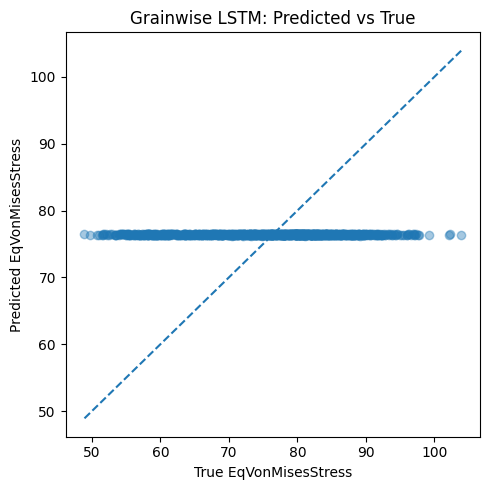

In [26]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch, lengths in val_loader:
        X_batch = X_batch.to(device)
        lengths = lengths.to(device)

        preds = model(X_batch, lengths)        # (B,1)
        preds = preds.cpu().numpy().ravel()    # (B,)

        y_true_list.append(y_batch.numpy().ravel())
        y_pred_list.append(preds)

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae  = np.mean(np.abs(y_true - y_pred))

print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation MAE : {mae:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.xlabel("True EqVonMisesStress")
plt.ylabel("Predicted EqVonMisesStress")
plt.title("Grainwise LSTM: Predicted vs True")
plt.tight_layout()
plt.show()
